In [1]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""
import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random
from gym_pdsystem.envs.pdsystem_env import PDSystemEnv

import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct


from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML


#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
episode_length = 30
seed = 42

system = PDSystemEnv()
env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


[42]

In [3]:
def leftmost_emptiest_tank_policy(s, system):
    min_boolean_indexes = np.isin(s, np.min(s))
    min_indexes = np.where(min_boolean_indexes)
    min_indexes = min_indexes[0]
    #n_min = len(min_indexes)

    possible_indexes = []
    
    for tank_visited in min_indexes:
        hypothetical_next_tank_state = s[tank_visited] + system.truck_max_loads
        #print(hypothetical_next_tank_state, system.tank_max_loads[tank_visited])
        if hypothetical_next_tank_state <= system.tank_max_loads[tank_visited]:
                    possible_indexes.append(tank_visited)
    
    
    if len(possible_indexes) != 0:
        tank_to_go = possible_indexes[0] # THIS IS WHAT CHANGES WITH RESPECT TO THE emptiest_tank_policy()
        return tank_to_go
    else:
        return system.n #stay in the depot

# Creating train, validation and test sets

In [4]:
################################################################################
# ENSURE THIS PARAMETER VALUES ARE SET AT THE BEGINNING OF THE pdsystem_env.py!!
################################################################################

# Example k = 1 (trucks), n = 3 (tanks)
TANK_MAX_LOADS = np.array([100., 200, 100.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9]
                                                   ])
TRUCK_MAX_LOADS = np.array([50.])
GRAPH_WEIGHTS = np.array([32., 159., 162., 0.])

DISCRETE = False
########################################

In [5]:
seed = 42
np.random.seed(seed)
system = PDSystemEnv()

N_TRAIN = 10**4; SEED_TRAIN = 42; train_file = 'train.txt'
N_VAL = 10**3; SEED_VAL = 50; validation_file = 'validation.txt'
N_TEST = 10**3; SEED_TEST = 58; test_file = 'test.txt'

round_decimals = 5

CREATE_DATASETS = False

def create_datasets(outputfile, n_observations, seed = None):   
    if seed != None:
        np.random.seed(seed)
        
    with open('{}'.format(outputfile),'w') as f:
        np.savetxt(f, [np.array(['tank1', 'tank2', 'tank3', 'target'])], fmt = "%s", delimiter=',')
        for i in range(n_observations):
            obs = []
            for max_load in TANK_MAX_LOADS:
                random_load = np.random.random() * max_load
                obs.append(np.round(random_load,round_decimals)  )

            obs.append(leftmost_emptiest_tank_policy(np.array(obs), system))   
            np.savetxt(f, [np.array(obs)], fmt = ('%f','%f', '%f', '%d'), delimiter=',')  #!! fmt only for n=3

if CREATE_DATASETS:          
    create_datasets(train_file, N_TRAIN, SEED_TRAIN) 
    create_datasets(validation_file, N_VAL, SEED_VAL)      
    create_datasets(test_file, N_TEST, SEED_TEST)            

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Exploring data sets

In [6]:
import pandas as pd

In [7]:
train = pd.read_table(train_file, sep = ",")
test = pd.read_table(test_file, sep = ",")
validation = pd.read_table(validation_file, sep = ",")

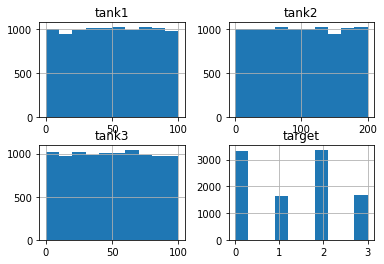

In [8]:
train.hist()
plt.show()

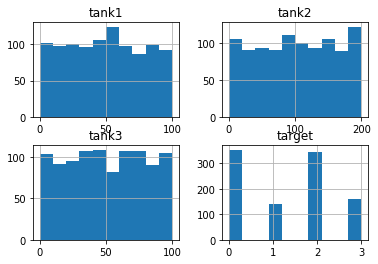

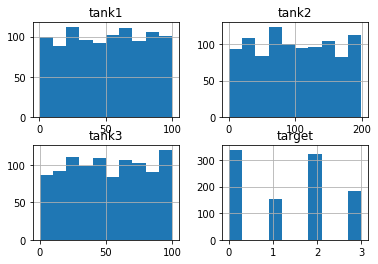

In [9]:
test.hist()
validation.hist()

plt.show()

In [10]:
y_train = train["target"].values#.reshape((N_TRAIN, ))
X_train = train[["tank1", "tank2","tank3"]].values

y_test = test["target"].values#.reshape((N_TEST, ))
X_test = test[["tank1", "tank2","tank3"]].values

y_val = validation["target"]#.reshape((N_VAL, ))
X_val = validation[["tank1", "tank2","tank3"]].values

In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

# Stochastic gradient descent classifier 

In [12]:
from sklearn.linear_model import SGDClassifier

In [13]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

In [14]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train);

## Cross validation accuracy

In [15]:
CV = 10

In [16]:
cvs = cross_val_score(sgd_clf, X_train, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score: ", np.mean(cvs))

Average cross validation score:  0.805050233881416


In [17]:
from sklearn.preprocessing import StandardScaler


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [19]:
cvs = cross_val_score(sgd_clf, X_train_scaled, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score for scaled train data: ", np.mean(cvs));

Average cross validation score for scaled train data:  0.9026149060019663


## Error Analysis

In [20]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = CV)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[3218,   33,   64,    8],
       [ 112, 1420,   45,   66],
       [ 198,   89, 3027,   52],
       [ 188,   64,   55, 1361]])

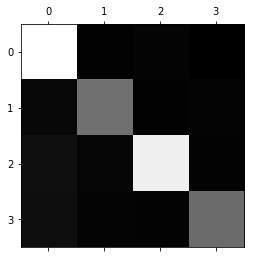

In [21]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [22]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

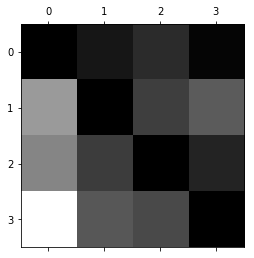

In [23]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

## Test prediction accuracy of the model trained on the whole train set

In [24]:
y_test_pred = sgd_clf.predict(X_test)

In [25]:
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[344,  10,   0,   0],
       [  9, 119,  13,   0],
       [ 30,  14, 300,   0],
       [ 73,  25,  16,  47]])

In [26]:
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.81

In [27]:
sgdscaled_clf = SGDClassifier(random_state = 42)
sgdscaled_clf.fit(X_train_scaled, y_train);

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

y_test_scaled_pred = sgdscaled_clf.predict(X_test_scaled)
conf_mx = confusion_matrix(y_test, y_test_scaled_pred)
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.928

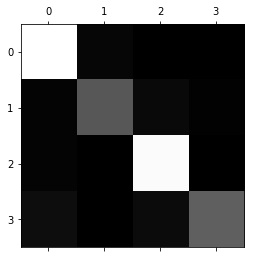

In [28]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [29]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

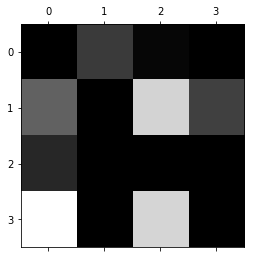

In [30]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Random forest classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_train, y_train);

## Cross validation accuracy

In [32]:
CV = 10

In [33]:
cvs = cross_val_score(rf_clf, X_train, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score: ", np.mean(cvs))

Average cross validation score:  0.9851987684034821


In [34]:
from sklearn.preprocessing import StandardScaler


In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [36]:
cvs = cross_val_score(rf_clf, X_train_scaled, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score for scaled train data: ", np.mean(cvs));

Average cross validation score for scaled train data:  0.9851987684034821


## Error Analysis

In [37]:
y_train_pred = cross_val_predict(rf_clf, X_train_scaled, y_train, cv = CV)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[3285,   17,   20,    1],
       [  23, 1594,   13,   13],
       [  32,   19, 3315,    0],
       [   0,   10,    0, 1658]])

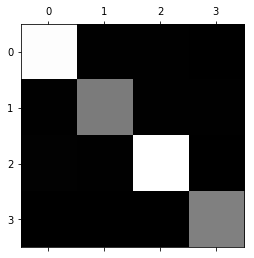

In [38]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [39]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

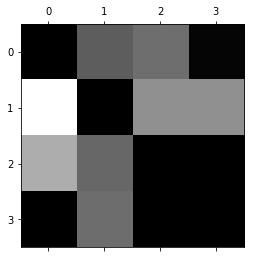

In [40]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

## Test prediction accuracy of the model trained on the whole train set

In [41]:
y_test_pred = rf_clf.predict(X_test)

In [42]:
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[349,   3,   2,   0],
       [  0, 140,   0,   1],
       [  2,   0, 342,   0],
       [  0,   2,   0, 159]])

In [43]:
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.99

In [44]:
rfscaled_clf = RandomForestClassifier(random_state = 42)
rfscaled_clf.fit(X_train_scaled, y_train);

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

y_test_scaled_pred = rfscaled_clf.predict(X_test_scaled)
conf_mx = confusion_matrix(y_test, y_test_scaled_pred)
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.977

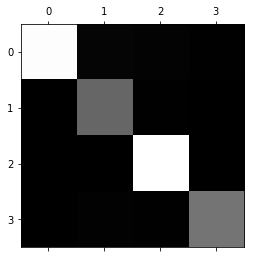

In [45]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [46]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

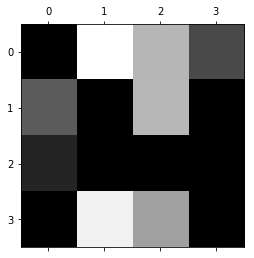

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Neural Network Classifier

In [48]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [49]:
class NNClassifier(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.
    """

    def __init__(self, sess, learning_rate, model_file = None):
        self.sess = sess
        self.learning_rate = learning_rate

        # Network architecture
        #self.action, self.y, self.X = self.create_network()
        self.action = self.create_network()

        self.network_params = tf.trainable_variables()
        
    def create_network(self):
       
        with tf.name_scope("dnn"):
            #inputs = tflearn.input_data(shape=[None, self.s_dim])
            tf.set_random_seed(seed)
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = 20; activation1 = tf.nn.elu
            n_hidden2 = 6; activation2 = tf.nn.elu
            n_outputs = env.action_space.shape[1]

            self.initializer = tf.contrib.layers.variance_scaling_initializer()

            # 2. Build the Neural Network
            
            self.X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            self.y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(self.X, n_hidden1, activation = activation1,
                                     kernel_initializer = self.initializer)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = self.initializer)
            logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = self.initializer)
            
        with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = self.y,
                                                                      logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
        with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.optimize = optimizer.minimize(loss)
            
        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, self.y, 1)
            self.accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
      
        with tf.name_scope("action"):
            outputs = tf.nn.softmax(logits)
            # 3. Select a random action (where to go) based on the estimated probabilities
            self.action = tf.multinomial(tf.log(outputs), num_samples = 1)

        self.init = tf.global_variables_initializer()
        
        if model_file != None:
            self.saver = tf.train.Saver()
        
        return self.action#, y, X

    def train(self,X,y):
        self.sess.run(self.optimize, feed_dict={
            self.y: y,
            self.X: X
        })

    def predict_action(self, X, y):
        return self.sess.run(self.action, feed_dict={
            self.X: X,
            self.y: y
        })
    
    def get_accuracy(self, X, y):
        return self.sess.run(self.accuracy, feed_dict={
            self.X: X,
            self.y: y
        })

    def get_num_trainable_vars(self):
        return self.num_trainable_vars
    
    def fetch_batch(self, X,y,epoch, batch_index, batch_size, data_size, n_batches):
        #np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
        indices = np.random.randint(data_size, size=batch_size)  # not shown
        X_batch = X[indices] # not shown
        y_batch = y[indices] # not shown
        return X_batch, y_batch

    def fit(self, X_train, y_train, X_val, y_val, epochs = 10, batch_size = 50, summary_freq = None):
        N_TRAIN = X_train.shape[0]
        m = y_train.shape[0]
        
        n_batches = int(np.ceil(N_TRAIN/ batch_size))
        #print(n_batches)
             
        for epoch in range(epochs+1):
            for batch_index in range(n_batches):
                X_batch, y_batch = self.fetch_batch(X_train,y_train,epoch, batch_index, batch_size, m, n_batches)
                #print("Xbatch shape",X_batch.shape, "y_batch shape", y_batch.shape)
                self.train(X_batch, y_batch)
            if summary_freq != None:    
                acc_train = self.get_accuracy(X_batch, y_batch)
                acc_val = self.get_accuracy(X_val, y_val)
                if epoch % summary_freq  == 0:
                    print("Epoch: ", epoch, " Train (batch) accuracy: ", acc_train, " Validation accuracy: ", acc_val)


In [50]:
reset_graph()

seed = 43
np.random.seed(seed)

epochs = 1
batch_size = 100

learning_rate = 0.01
summary_freq = np.ceil(epochs/10)


model_file = None#'./final_nn_classifier.ckpt'


with tf.Session() as sess:

                nn_clf = NNClassifier(sess, learning_rate, model_file)
                nn_clf.init.run()
                nn_clf.fit(X_train, y_train, X_val, y_val, epochs = epochs, batch_size = batch_size, summary_freq = summary_freq)
                acc_test = nn_clf.get_accuracy(X_test, y_test)
                acc_train = nn_clf.get_accuracy(X_train, y_train)

                print("All Train accuracy", acc_train, " Test accuracy: ", acc_test)

Instructions for updating:
Use the retry module or similar alternatives.
Epoch:  0  Train (batch) accuracy:  0.82  Validation accuracy:  0.868
Epoch:  1  Train (batch) accuracy:  0.89  Validation accuracy:  0.895
All Train accuracy 0.9092  Test accuracy:  0.901


In [51]:
reset_graph()

# sess = tf.Session() 
with tf.Session() as sess:
    #reset_graph()
    #nn_clf = NNClassifier(sess, learning_rate, model_file)
    #nn_clf.init.run()
    #saver = tf.train.import_meta_graph('./final_nn_classifier.ckpt.meta')
    print(    nn_clf.learning_rate)
    nn_clf.sess = sess
    nn_clf.create_network()
    
    #nn_clf.saver.restore(sess, './final_nn_classifier.ckpt')
    #print(    nn_clf.learning_rate)
    #acc_test = nn_clf.get_accuracy(X_test, y_test)
    #print(" Test accuracy: ", acc_test)

0.01


## Saving and restoring models

In [ ]:
reset_graph()

seed = 42
learning_rate = 0.01

model_file = './final_nn_classifier_{}.ckpt'.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)
epochs = 2000
batch_size = 50

summary_freq = np.ceil(epochs/10)


hidden1_neurons = 100
hidden2_neurons = 50


with tf.name_scope("dnn"):
            #inputs = tflearn.input_data(shape=[None, self.s_dim])
            tf.set_random_seed(seed)
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.elu
            n_outputs = env.action_space.shape[1]

            initializer = tf.contrib.layers.variance_scaling_initializer()

            # 2. Build the Neural Network
            
            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = initializer)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = initializer)
            logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = initializer)
            
with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,
                                                                      logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            optimize = optimizer.minimize(loss)
            
with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
            
with tf.name_scope("action"):
            outputs = tf.nn.softmax(logits)
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)

init = tf.global_variables_initializer()
        
if model_file != None:
            saver = tf.train.Saver()
        

def fetch_batch(X,y,epoch, batch_index, batch_size, data_size, n_batches):
        #np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
        indices = np.random.randint(data_size, size=batch_size)  # not shown
        X_batch = X[indices] # not shown
        y_batch = y[indices] # not shown
        return X_batch, y_batch
    
    
best_acc_val = 0
acc_val = 0
# early_stopping = True
# stopping_counter = 0
# max_stopping_counter = 100

with tf.Session() as sess:
        init.run()
        N_TRAIN = X_train.shape[0]
        m = y_train.shape[0]
        
        n_batches = int(np.ceil(N_TRAIN/ batch_size))
        #print(n_batches)
             
        for epoch in range(epochs+1):
            for batch_index in range(n_batches):
                X_batch, y_batch = fetch_batch(X_train,y_train,epoch, batch_index, batch_size, m, n_batches)
                #print("Xbatch shape",X_batch.shape, "y_batch shape", y_batch.shape)
                sess.run(optimize, feed_dict={
                                    y: y_batch,
                                    X: X_batch
                                })
    
            if summary_freq != None: 
                            
                if epoch % summary_freq  == 0:
                    

                    acc_train = sess.run(accuracy, feed_dict={
                                        y: y_batch,
                                        X: X_batch
                                    })
                    acc_val = sess.run(accuracy, feed_dict={
                                        y: y_val,
                                        X: X_val
                                    }) 
                                    
                    
                    best_acc_val = max(best_acc_val, acc_val)

                    #print(acc_val, best_acc_val)

                    print("Epoch: ", epoch, " Train (batch) accuracy: ", acc_train, 
                          " Validation accuracy: ", acc_val)
                    if best_acc_val <= acc_val:                        
                        save_path = saver.save(sess, model_file)
                        print("Saved model with validation accuracy ", acc_val)
                                     
        #save_path = saver.save(sess, model_file)   

Epoch:  0  Train (batch) accuracy:  0.94  Validation accuracy:  0.899
Saved model with validation accuracy  0.899
Epoch:  200  Train (batch) accuracy:  0.98  Validation accuracy:  0.976
Saved model with validation accuracy  0.976
Epoch:  400  Train (batch) accuracy:  0.98  Validation accuracy:  0.989
Saved model with validation accuracy  0.989
Epoch:  600  Train (batch) accuracy:  1.0  Validation accuracy:  0.985
Epoch:  800  Train (batch) accuracy:  1.0  Validation accuracy:  0.982
Epoch:  1000  Train (batch) accuracy:  1.0  Validation accuracy:  0.991
Saved model with validation accuracy  0.991
Epoch:  1200  Train (batch) accuracy:  1.0  Validation accuracy:  0.994
Saved model with validation accuracy  0.994
Epoch:  1400  Train (batch) accuracy:  1.0  Validation accuracy:  0.995
Saved model with validation accuracy  0.995
Epoch:  1600  Train (batch) accuracy:  1.0  Validation accuracy:  0.987


In [74]:
learning_rate = 0.01

model_file = './final_nn_classifier_{}.ckpt'.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)

#saver = tf.train.import_meta_graph(graph_file)
#y = tf.get_default_graph().get_tensor_by_name("dnn/y:0") # not shown in the book
#X = tf.get_default_graph().get_tensor_by_name("dnn/X:0")

with tf.Session() as sess: 
    saver.restore(sess, model_file)
    acc_test = sess.run(accuracy, feed_dict={
                                    y: y_test,
                                    X: X_test
                               })
    print(" Test accuracy of the best model saved (according to validation accuracy): ", acc_test)
    
    

INFO:tensorflow:Restoring parameters from ./final_nn_classifier_0.01.ckpt
 Test accuracy of the best model saved (according to validation accuracy):  0.985


## "Playing" the product delivery game with the learnt policy

In [69]:
episode_length = 30
seed = 42

system = PDSystemEnv()
env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

test  = True

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [70]:
def leftmost_emptiest_tank_policy(s, system):
    min_boolean_indexes = np.isin(s, np.min(s))
    min_indexes = np.where(min_boolean_indexes)
    min_indexes = min_indexes[0]
    #n_min = len(min_indexes)

    possible_indexes = []
    
    for tank_visited in min_indexes:
        hypothetical_next_tank_state = s[tank_visited] + system.truck_max_loads
        #print(hypothetical_next_tank_state, system.tank_max_loads[tank_visited])
        if hypothetical_next_tank_state <= system.tank_max_loads[tank_visited]:
                    possible_indexes.append(tank_visited)
    
    
    if len(possible_indexes) != 0:
        tank_to_go = possible_indexes[0] # THIS IS WHAT CHANGES WITH RESPECT TO THE emptiest_tank_policy()
        return np.array([tank_to_go])
    else:
        return np.array([system.n]) #stay in the depot

In [71]:
frames = []
n_episodes = 10

with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                img = system.visualize()
                frames.append(img)

                action_val = action.eval(feed_dict={X: state.reshape(1, n_inputs)})
 
                state, reward, done, info = env.step(action_val[0])
                #print(action_val[0],emptiest_tank_policy(state, system))
        
                if done:
                    break
        env.close()
    

INFO:tensorflow:Restoring parameters from ./final_nn_classifier_0.01.ckpt


In [72]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

In [ ]:
np.inf

In [65]:
acc_val = 2
last_acc_val = 1
last_acc_val = acc_val
last_acc_val = last_acc_val + 1
last_acc_val

3

In [63]:
acc_val

2